In [64]:
import gym
import torch
import random
import IPython
import os

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from copy import deepcopy
from PIL import Image
from IPython import display
from matplotlib import cm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Useful functions

In [65]:
def set_seeds(seed=123):
    """
    Set seeds for reproducibility. This will also help
    explore other solutions to the same configuration.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

# We'll call this function right away.
set_seeds()

def space_dynamics(positions, old_I, initial_I, t, tau, kappa, sigma):
    """
    Dynamics of the space. This gets the change of food with respect to the 
    state of the board (i.e., the positions of the robots) as well as some 
    constants specified by the caller. 
    
    Args:
        positions (list): a list of positions of the robots. A singleton for now.
        old_I (list): a np.array of shape x_dim, y_dim containing the old food distro.
        initial_I (list): a np.array of shape x_dim, y_dim containing the initial food distro.
        t (int): the board time. Unused for now.
        tau (float): the recovery rate.
        kappa (float): the consumption rate.
        sigma (float): the standard deviation.
        
    Returns:
        delta_I, the change in food.
    """
    # TODO: add support for more than one robot.
    robot_x = positions["0"][0]
    robot_y = positions["0"][1]
    
    delta_I = np.zeros(old_I.shape)
    
    for i in range(old_I.shape[0]):
        for j in range(old_I.shape[1]):
            dx = (i - robot_x)**2
            dy = (j - robot_y)**2
            exponent = (dx + dy)/(2*(sigma**2))
            delta_I[i][j] = (1/tau)*(initial_I[i][j] - old_I[i][j]) - kappa*np.exp(-exponent)

    return delta_I


### Lightboard class definition
 - 2D for now
 - Allows for loading/checkpointing

In [66]:
IMPASSABLE_FOOD = 0 # TODO: does this make sense?
MAX_VAL = 9999999 # TODO: this is to avoid gradient explosion.

class Cell():
    """
    A cell for the board. Contains information relevant to the experiment.
    
    Args:
        x (int): the x-position of the board (immutable).
        y (int): the y-position of the board (immutable).
        food (float): the amount of food on this cell.
        time (int): the current simulation time.
        has_agent (bool): whether an agent is present in this cell.
        is_blocking (bool): whether this is an impassable tile (mountains, holes, etc.) Useful for mazes
                            and more complex boards. Default to False for now.
    """
    def __init__(self, x, y, food, time, has_agent, is_impassable=False):
        super(Cell, self).__init__()
        self._time = time
        self._x = x
        self._y = y
        # TODO: These three variables should be accessible through a method.
        self._food = food
        self.has_agent = has_agent
        self.is_impassable = is_impassable

    def get_food(self):
        """
        Get the amount of food in the cell, if any.
        """
        if self.is_impassable:
            # TODO: should we also return IMPASSABLE_FOOD when it is occupied,
            # or should we trust the bot to eventually learn it can't move there?
            return IMPASSABLE_FOOD
        else:
            return self._food


class Board(gym.Env):
    """ 
    The lightboard class. It is a stateful object that records positions of the agents and food
    available on every cell.
    It is also able to optionally render a movie.
        
    Args:
        agent_positions (list) : A list of tuples (x,y) with the initial positions of the agents.
        grid (optional, list): a list of Cell objects representing a pre-designed grid, if existing.
        x_dim (optional, int): the width of the board. Default: 640.
        y_dim (optional, int): the height of the board. Default: 640.
        do_movie (optional, bool): whether to render a movie while working on the simulation.
        ckpt_dir (optional, str): the checkpoint directory to save all tmp files.
        
        I (optional, list): the resource profile. Its dimensions must match x_dim and y_dim. If not
                            specified, it will be randomly generated at start.
        tau (optional, float): the recovery rate. Default: 10
        kappa (optional, float): the consumption rate. Default: 1
        sigma (optional, float): the standard deviation. Default: 20
    """
    def __init__(self, agent_positions, grid=None, x_dim=640, y_dim=640,
                       do_movie = True, render = True, ckpt_path = "",
                       I = None, kappa=1, tau=10, sigma=4):
        self._ckpt_path = ckpt_path
        self._n_agents = len(agent_positions)
        self._agent_positions = {str(i): deepcopy(j) for i, j in enumerate(agent_positions)}
        self._agent_colors = {str(i): None for i in range(len(agent_positions))}
        self._action_to_coordinates = {"0": [0, 0],
                                       "1": [-1, 0],
                                       "2": [1, 0],
                                       "3": [0, -1],
                                       "4": [0, 1]
                                      } # TODO: diagonal movements
        self._x_dim = x_dim
        self._y_dim = y_dim
        self._time = 0
        self._images = []
        self._do_movie = do_movie
        self._render = render
        
        # Food stuffs
        self._I = np.random.rand(self._x_dim, self._y_dim) if I is None else deepcopy(I)
        self._initial_I = deepcopy(self._I)
        assert (x_dim == self._I.shape[0]), "Dimension mismatch! Did you specify x_dim?"
        assert (y_dim == self._I.shape[1]), "Dimension mismatch! Did you specify y_dim?"
        self._kappa = kappa
        self._tau = tau
        self._sigma = sigma

        # Create a random grid if it's not specified.
        # The grid object holds the Cell object.
        if grid is None:
            self._grid = [[None for _ in range(self._x_dim)] for _ in range(self._y_dim)]
            # Create a random grid
            for i in range(self._x_dim):
                for j in range(self._y_dim):
                    has_agent = (i, j) in agent_positions
                    is_impassable = False
                    food = self._I[i][j] # When we start, this should only be I(x,y, t=0)
                    self._grid[i][j] = Cell(i, j,
                                            food=food,
                                            time=self._time,
                                            has_agent=has_agent,
                                            is_impassable=is_impassable)

        # Save a render of our inital state.
        if self._do_movie or self._render:
            img = self.board_to_image()
            self._images.append(img)
        if self._render:
            self._render_current_state()
                    
        # Gym-specific stuff. This one is for sampling:
        self.action_space = gym.spaces.Discrete(5)

        
    def step(self, agent_action, agent_id, update_time=False):
        """
        Return the next state at time t based on the action of  a given agent.
        Update the agent positions and return the new state of the board. 
        For now we will consider a reward of 0 if the move is unsuccessful, 1
        otherwise; and focus on food as observation.
            
        Args:
            agent_action (int): An action taken by a given agent.
            agent_id (int): The agent's ID for rendering and so forth. For now we assume 
                            that it is an integer in [0,..., n_agents -1].
            update_time (bool): Whether to update the time on the board. This should
                                be called by the last agent.
            
        Returns:
            A tuple of the form (observation, reward, is_done, is_successful)
        """
        # Convert integer to coordinates and get the new position.
        action_x, action_y = self._action_to_coordinates[str(agent_action)]        
        old_x, old_y = self._agent_positions[str(agent_id)][0], self._agent_positions[str(agent_id)][1]
        new_x, new_y = old_x + action_x, old_y + action_y
        
        is_done = False
        reward = 1
        observation = None # This will be the food. 
        # Step 1: Figure out what the next state of the agent will be.
        is_successful = self.is_movement_successful(new_x, new_y, old_x, old_y)
        
        if not is_successful:
            reward = 0
            new_x, new_y = old_x, old_y
        else:
            self._agent_positions[str(agent_id)] = deepcopy([new_x, new_y])
            self._grid[new_x][new_y].has_agent = True
            self._grid[old_x][old_y].has_agent = False
            reward += self._grid[new_x][new_y]._food

        # Step 2: update local food based on consumption rate, and generate new 
        # observation of neighboring tiles.
        old_food = self._grid[old_x][old_y]._food
        self._grid[old_x][old_y]._food = max(old_food - self._kappa*old_food, 0)
        self._grid[old_x][old_y]._food = min(old_food, MAX_VAL)
        observation = self.get_observation_from_coords(new_x, new_y)

        # Step 3: Finally, if done with all the agents, do rendering/updating.
        if update_time:
            # First do the rendering stuff
            if self._do_movie or self._render:
                img = self.board_to_image()
                self._images.append(img)
            if self._render:
                self._render_current_state()
            # Then update the food.
            self._update_board_state()
            
        return (observation, reward, is_done, {"success": is_successful})
    
    def _update_board_state(self):
        """
        Update the food based on the dynamics until now.
        """
        self._time += 1
        delta_I = space_dynamics(positions=self._agent_positions,
                                 old_I=self._I,
                                 initial_I=self._initial_I,
                                 t = self._time,
                                 tau=self._tau, kappa=self._kappa, sigma=self._sigma)
        self._I += self._time*delta_I
        for i in range(self._x_dim):
            for j in range(self._y_dim):
                self._grid[i][j]._food = self._I[i][j]

    def get_observation_from_coords(self, x, y):
        coords = {"0": [0, 0], "1": [-1, 0], "2": [1, 0], "3": [0, -1], "4": [0, 1]}
        obs = []
        for k,v in coords.items():
            v_x, v_y = v[0], v[1]
            if x  + v_x < 0:
                obs.append(IMPASSABLE_FOOD)
            elif y + v_y < 0:
                obs.append(IMPASSABLE_FOOD)
            elif x + v_x >= self._x_dim:
                obs.append(IMPASSABLE_FOOD)
            elif y + v_y >= self._y_dim:
                obs.append(IMPASSABLE_FOOD)
            else:
                obs.append(self._grid[x + v_x][y + v_y].get_food())
        return obs
    
    def is_movement_successful(self, new_x, new_y, old_x, old_y):
        """
        Test if the new coordinates are valid, based off the action taken
        by the agent.
        
        Args:
            new_x (int): new x-coordinate from the agent's action
            new_y (int): new y-coordinate from the agent's action
            old_x (int): old x-coordinate from the agent's action
            old_y (int): old y-coordinate from the agent's action
            
        Returns:
            Whether the next move is successful.
        """
        if new_x < 0 or new_x >= self._x_dim:
            return False
        if new_y < 0 or new_y >= self._y_dim:
            return False
        if self._grid[new_x][new_y].has_agent and new_x != old_x and old_y != new_y:
            return False
        if self._grid[new_x][new_y].is_impassable:
            return False
        return True
    
    def board_to_image(self):
        """
        Convert the board to an image and render it. The idea here will be to assign 
        a color to each of the agents, and render the board with the food shown as 
        different shades of grey.
        We will render impassable tiles as pure black.

        Returns:
            A color-coded image of the board.
        """
        tmp_grid = np.zeros((self._x_dim, self._y_dim))
        for i in range(self._x_dim):
            for j in range(self._y_dim):
                cell = self._grid[i][j]
                value = 0
                if cell.is_impassable:
                    value = 0
                else:
                    value = cell.get_food()
                tmp_grid[i][j] = value
        cm = plt.get_cmap("gist_earth")
        img = cm(tmp_grid)
        background = Image.fromarray((img[:, :, :3]*255).astype(np.uint8))
        foreground = Image.new("RGBA", (self._x_dim, self._y_dim), (0,0,0,0))
        for coords in self._agent_positions.values():
            foreground.putpixel(coords, (255, 51, 51, 255)) #Red
        background.paste(foreground, (0, 0), foreground)
        
        return background
    
    def _render_current_state(self):
        """
        Draw the movie on the fly.
        """
        fig = plt.figure(len(self._images))
        plt.clf()
        plt.imshow(self._images[-1])
        fig.canvas.draw()
        plt.pause(0.00001)
        return

    def load_grid_from_file(self, grid_path):
        """
        Assume it's a pickle file for now.
        
        Args:
            grid_path (str, required): a path to a pickle file containing the saved
                                       grid.
        """
        self._grid = pickle.load(open(grid_path, "rb"))
    
    def checkpoint(self, name=None):
        """
        Checkpoint the grid as a pickle file. 
        
        Args:
            name (str, required): an optional string for a custom name. Defaults
                                  to 'grid_<time>.pb'.
        """
        if name is None:
            name = "grid_" + str(self._time)
        dump_path = os.path.join(self._ckpt_path, "/", name, ".pb")
        pickle.dump(open(dump_path, "wb"))

    def do_movie(self, delay=1e-5, name="movie.gif", play_on_finish=False):
        """
        Render and save the video.
        
        Args:
            delay (float, optional): how fast will the movie play.
            name (str, optional): the name of the movie when saved.
            play_on_finish (str, optional): whether to play the newly rendered movie.
        """
        dump_path = os.path.join(self._ckpt_path, name)
        self._images[0].save(dump_path,
                             save_all=True,
                             append_images=self._images[1:],
                             optimize=False,
                             duration=delay,
                             loops=10)
        if play_on_finish:
            with open(dump_path, 'rb') as f:
                display.Image(data = f.read(), format='png')

### Agent definition
- Stateful, so we can define more than one

In [75]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=None):
        """ Simple two-layer neural network.
        """
        super(NeuralNetwork, self).__init__()
        if hidden_dim is None:
            hidden_dim = in_dim*2
        self.l1 = nn.Linear(in_dim, hidden_dim)
        self.ac1 = nn.ReLU()
        self.l2 = nn.Linear(hidden_dim, out_dim)
        self.ac2 = nn.Softmax()
        
    def forward(self, x):
        x = self.ac1(self.l1(x))
        return self.ac2(self.l2(x))

class Agent():
    """ The agent (bot).
    
        Args:
            n_dof (int, optional): the degrees of freedom of the bot. In other words,
                                   whether it can only move sideways/up/downward, or also
                                   in diagonal. It includes the choice of not moving and the reward.
                                   Default: 1+1+4
            lr (float, optional): the learning rate at which to perform optimization.
            rho (float, optional): the momentum for the optimizer (SGD only).
    """
    def __init__(self, pos_x, pos_y, n_dof=6, lr=0.0001, rho=0.9):
        super(Agent, self).__init__()
        self._n_dof = n_dof
        self._model = NeuralNetwork(in_dim=self._n_dof, out_dim=self._n_dof - 1)
        self._optimizer = optim.SGD(self._model.parameters(), lr=lr, momentum=rho)
        self._loss = nn.MSELoss()
        self.position_x = pos_x
        self.position_y = pos_y
        self.past_reward = 0.
        self.action_to_position = {"0": [0, 0],
                                   "1": [-1, 0],
                                   "2": [1, 0],
                                   "3": [0, -1],
                                   "4": [0, 1]}
        self.softmax = nn.Softmax()
        self.relu = nn.ReLU()

    def observation_to_label(self, obs):
        """
        Convert an observation into a label that can be used by our model.
        """
        return self.softmax(self.relu(torch.tensor(obs)))
 
    def act(self, state):
        """
        Act given a state.
        
        Args:
            state (list): The current state observed by the robot (all the visible tiles
                          along with their food).
        """
        self._model.eval()
        out = self._model(torch.tensor([self.past_reward]+ state))
        return np.argmax(out.detach().cpu().numpy())
        
    def update(self, observation, reward, is_successful):
        """
        Update our agent.
        
        Args:
           observation (list): the observation for this agent (all the visible tiles)
           reward (float): the reward obtained by the model.
           is_successful (bool): whether the move was successful. Needed to
                                 update the internal coordinates of the model.
        """
        self._model.train()
        self.past_reward = reward
        out = self._model(torch.tensor([reward] + observation))
        loss = self._loss(out, self.observation_to_label(observation))
        loss.backward()
        _ = nn.utils.clip_grad_norm(self._model.parameters(), 5.0) # Needed to avoid NaNs
        self._optimizer.step()
        self._optimizer.zero_grad()
        
        if is_successful:
            out = np.argmax(out.detach().cpu().numpy())
            shift = self.action_to_position[str(int(out))]
            self.position_x = self.position_x + shift[0]
            self.position_y = self.position_y + shift[1]


### Algorithm

In [76]:
def coevolve(board, all_agents, total_timesteps=50, do_movie=True):

    t = 0
    is_done = False # This will never be called for now.
    while t < total_timesteps:
        # Update the board one-by-one
        for i, agent in enumerate(all_agents):
            state = board.get_observation_from_coords(agent.position_x, agent.position_y)
            action = int(agent.act(state))
            print(action, state)
            obs, rew, is_done, is_successful =  board.step(agent_action=action,
                                                           agent_id=i,
                                                           update_time=(i == len(all_agents) - 1))
            agent.update(obs, rew, is_successful)
            
        t += 1

    if do_movie:
        board.do_movie()

### Setup variables

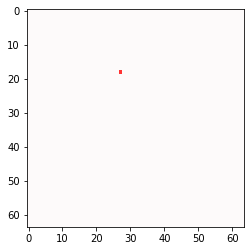

In [77]:
board_x_dim = 64
board_y_dim = 64

all_agents = [Agent(pos_x = random.randint(1, board_x_dim - 1), pos_y = random.randint(1, board_y_dim - 1))]
agent_positions = [(a.position_x, a.position_y)  for a in all_agents]
board = Board(agent_positions,
              x_dim = board_x_dim,
              y_dim = board_y_dim,
              kappa = 0.5,
              tau = 0.25,
              I = np.ones((board_x_dim, board_y_dim)))

### Run the simulation!

2 [1.0, 1.0, 1.0, 1.0, 1.0]


D:\Users\Adrian\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


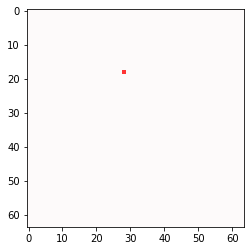

D:\Users\Adrian\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
D:\Users\Adrian\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


2 [0.5, 0.5153833827618279, 0.5153833827618279, 0.5153833827618279, 0.5153833827618279]


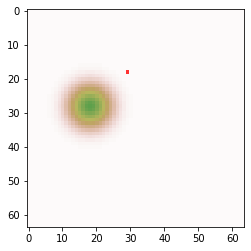

3 [3.3923163206672045, 3.530766765523656, 3.11950592456974, 3.3187124853708214, 3.3187124853708214]


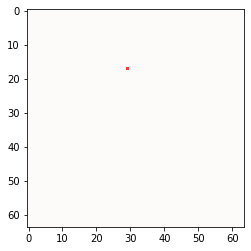

2 [-26.005837339079036, -27.435785688105533, -23.051101262102048, -23.677179024619736, -26.769329379053765]


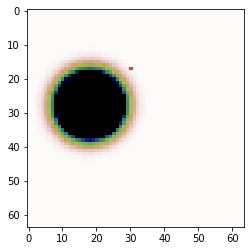

3 [359.7665189315307, 404.14909361723284, 300.2937605501616, 328.82380066236215, 369.91680499835763]


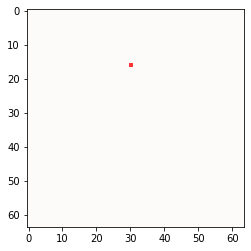

2 [-6230.1522125848805, -6998.721408715902, -5199.105827638366, -5349.194099908194, -6817.986942785274]


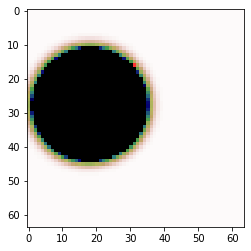

3 [119600.4340356824, 143314.59318974882, 93545.17823973765, 102724.4774053975, 130843.48191182895]


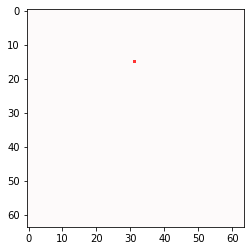

2 [-2773536.3899457324, -3322396.8359012213, -2170090.1224517105, -2238415.6703219838, -3229187.111279745]


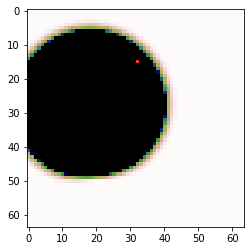

3 [67272821.79600303, 85979656.21138477, 49319522.76019631, 54313979.409942746, 78296576.23604478]


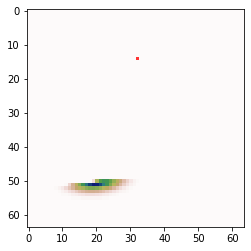

2 [-1900989247.8479962, -2428681959.143073, -1394257627.1864023, -1442226414.9618025, -2354548731.221656]


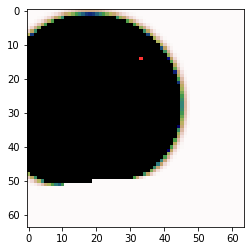

3 [54376047495.26969, 74138580701.2257, 37357647384.62064, 41272028541.0164, 67321147363.68881]


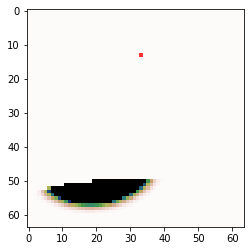

2 [-1774697227225.2053, -2418613699370.3, -1219871124411.705, -1265820120697.9912, -2338170042257.9277]


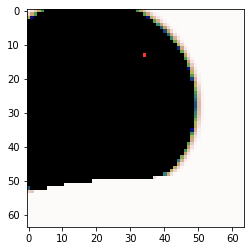

3 [57333942847392.14, 83410769679626.84, 36903200436350.28, 40915619997870.89, 75499805362535.34]


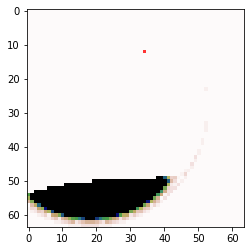

2 [-2086696619891369.8, -3034170829315199.5, -1343909507566360.8, -1399446581862624.2, -2924031085216954.0]


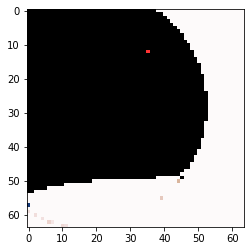

3 [7.391502291614987e+16, 1.1476831409402539e+17, 4.455915803187643e+16, 4.960229814639436e+16, 1.0351347722396006e+17]


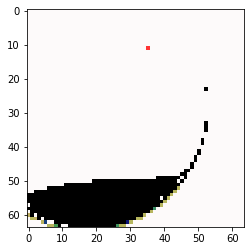

2 [-2.9265355906372675e+18, -4.541204158144219e+18, -1.7654931034581942e+18, -1.8457181063907707e+18, -4.3609863520528425e+18]


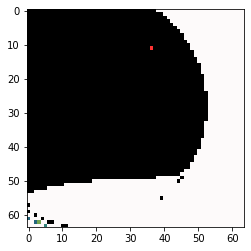

3 [1.1122606551786624e+20, 1.8437174221014784e+20, 6.277916658474621e+19, 7.020073573024888e+19, 1.6562639040448466e+20]


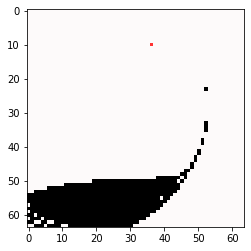

2 [-4.703449293926675e+21, -7.790776127075443e+21, -2.6570140733711e+21, -2.7900996436936245e+21, -7.452146389697037e+21]


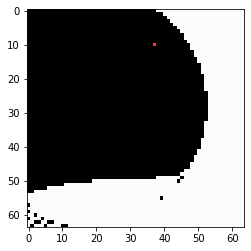

3 [1.886479992093481e+23, 3.33944899868794e+23, 9.965423436104052e+22, 1.1200609138162524e+23, 2.9864049544363777e+23]


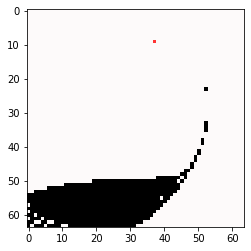

2 [-8.400456853621893e+24, -1.4857280602668552e+25, -4.44210920079136e+24, -4.6880177446411825e+24, -1.4148599940701107e+25]


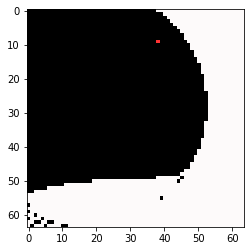

3 [3.509266268625175e+26, 6.636360914361294e+26, 1.7341904576611882e+26, 1.960494301213982e+26, 5.904513385891651e+26]


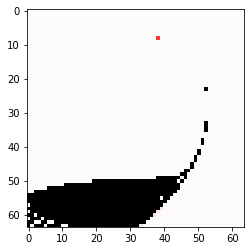

2 [-1.627210270007605e+28, -3.0739332351612237e+28, -8.051169404921567e+27, -8.545190200631212e+27, -2.912691002958895e+28]


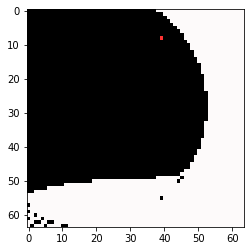

3 [7.004517382281764e+29, 1.4156729349066163e+30, 3.23641659262297e+29, 3.68310157822835e+29, 1.2522589294771439e+30]


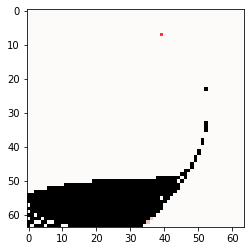

2 [-3.3516224361877986e+31, -6.7652270818397305e+31, -1.5509253055694044e+31, -1.656739802498919e+31, -6.374110817876405e+31]


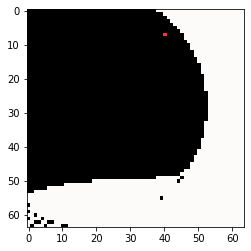

3 [1.4733790402909342e+33, 3.184041314378408e+33, 6.36112718524949e+32, 7.294377777118607e+32, 2.797882144322558e+33]


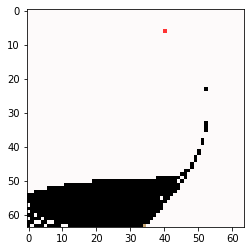

2 [-7.22143399934742e+34, -1.5581637842502333e+35, -3.123466682683363e+34, -3.361232387102091e+34, -1.4586452498880248e+35]


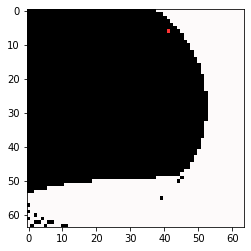

3 [3.217170683163864e+36, 7.438077019327843e+36, 1.2968917796788309e+36, 1.5002716332368364e+36, 6.486441390798906e+36]


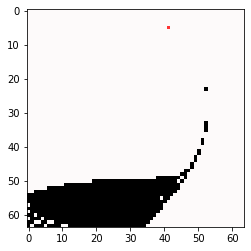

0 [-1.605290647563415e+38, -3.704414213825214e+38, -6.4857472400032405e+37, -7.038662372614232e+37, -3.442372630985334e+38]


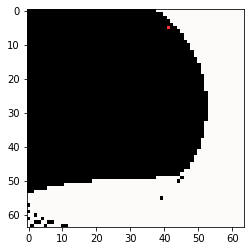

0 [1.7818726187953904e+40, 4.111899777345988e+40, 7.199179436403597e+39, 7.812915233601797e+39, 3.821033620393721e+40]


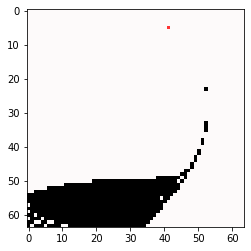

0 [-2.049153511614699e+42, -4.728684743947886e+42, -8.279056351864137e+41, -8.984852518642067e+41, -4.394188663452779e+42]


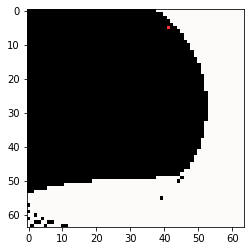

0 [2.4384926788214916e+44, 5.6271348452979845e+44, 9.852077058718323e+43, 1.069197449718406e+44, 5.229084509508807e+44]


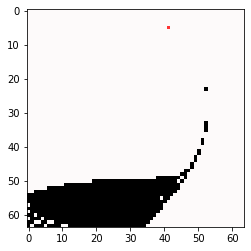

0 [-2.999345994950435e+46, -6.921375859716521e+46, -1.211805478222354e+46, -1.3151128631536394e+46, -6.431773946695833e+46]


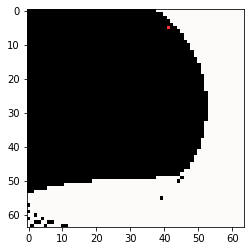

0 [3.809169413587052e+48, 8.790147341839982e+48, 1.5389929573423894e+48, 1.670193336205122e+48, 8.168352912303707e+48]


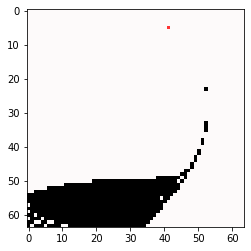

0 [-4.990011931799039e+50, -1.1515093017810376e+51, -2.01608077411853e+50, -2.18795327042871e+50, -1.0700542315117857e+51]


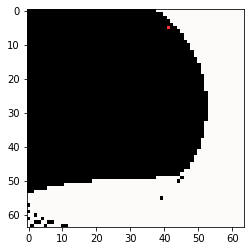

0 [6.736516107928702e+52, 1.5545375574044007e+53, 2.7217090450600157e+52, 2.953736915078758e+52, 1.4445732125409105e+53]


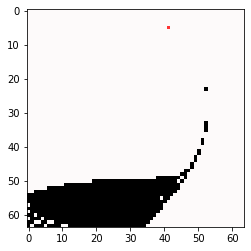

0 [-9.363757390020895e+54, -2.1608072047921168e+55, -3.783175572633422e+54, -4.105694311959474e+54, -2.0079567654318658e+55]


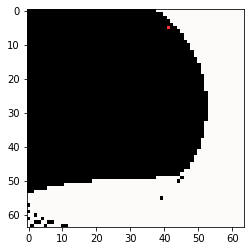

0 [1.339017306772988e+57, 3.089954302852727e+57, 5.409941068865793e+56, 5.871142866102047e+56, 2.871378174567568e+57]


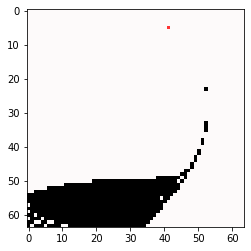

0 [-1.9683554409562924e+59, -4.5422328251935085e+59, -7.952613371232717e+58, -8.63058001317001e+58, -4.2209259166143245e+59]


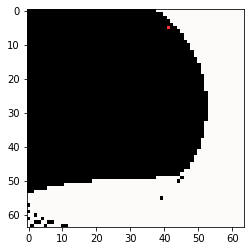

0 [2.9722167158440014e+61, 6.858771566042198e+61, 1.2008446190561403e+61, 1.3032175819886715e+61, 6.37359813408763e+61]


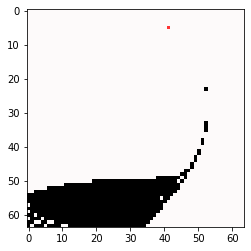

0 [-4.606935909558202e+63, -1.0631095927365406e+64, -1.8613091595370173e+63, -2.0199872520824407e+63, -9.879077107835827e+63]


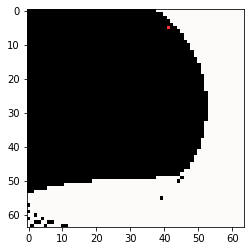

0 [7.325028096197542e+65, 1.6903442524510995e+66, 2.959481563663858e+65, 3.211779730811081e+65, 1.5707732601458963e+66]


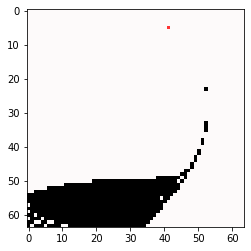

0 [-1.1939795796801993e+68, -2.755261131495292e+68, -4.823954948772088e+67, -5.2352009612220615e+67, -2.560360414037811e+68]


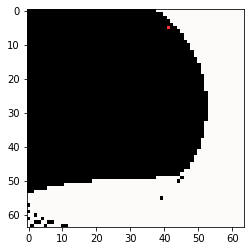

0 [1.9939458980659328e+70, 4.601286089597138e+70, 8.056004764449386e+69, 8.742785605240843e+69, 4.2758018914431444e+70]


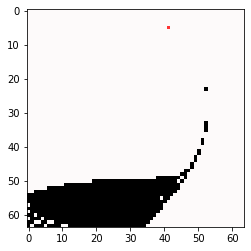

0 [-3.4096474856927452e+72, -7.868199213211106e+72, -1.377576814720845e+72, -1.4950163384961843e+72, -7.311621234367776e+72]


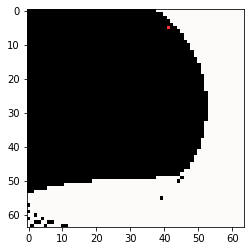

0 [5.966883099962304e+74, 1.3769348623119436e+75, 2.410759425761479e+74, 2.6162785923683224e+74, 1.2795337160143607e+75]


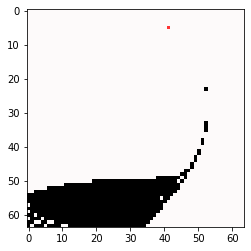

0 [-1.0680720748932524e+77, -2.464713403538379e+77, -4.3152593721130475e+76, -4.683138680339297e+76, -2.2903653516657057e+77]


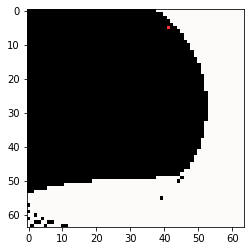

0 [1.9545718970546518e+79, 4.5104255284752345e+79, 7.896924650966877e+78, 8.570143785020914e+78, 4.1913685935482415e+79]


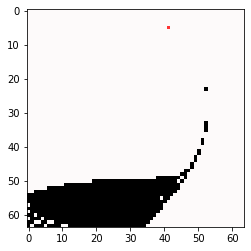

0 [-3.655049447492199e+81, -8.434495738248688e+81, -1.476724909730806e+81, -1.602616887798911e+81, -7.837859269935211e+81]


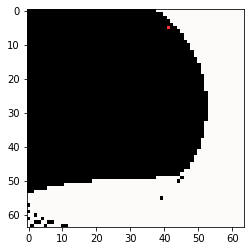

0 [6.9811444447101e+83, 1.6109886860054992e+84, 2.82054457758584e+83, 3.0609982556959204e+83, 1.4970311205576253e+84]


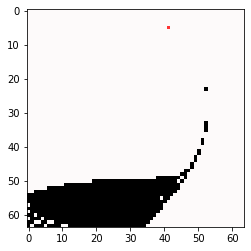

0 [-1.3613231667184695e+86, -3.1414279377107237e+86, -5.500061926292387e+85, -5.968946598607045e+85, -2.9192106850873694e+86]


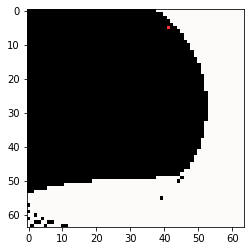

In [78]:
coevolve(board, all_agents)